# Assignment 2
The objective of this assignment is to introduce you to function specific neural networks. In otherwords, we will try and design neural networks based on insights from existing optimization algorithms. In the process, you will realize that while deep neural networks can, in theory, be generalized to learn arbitrary functions, design choices determine how easily and quickly they are able to learn those functions.

Additionally, when the training process starts, the model has to learn a particular mapping with no prior hint about the kind of function it is looking for. By introducing a structure which correlates to optimization objectives, neural networks can effectively be helped in narrowing done the choice of functions and parameters to be learnt.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import torch
import pickle
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
# from google.colab import drive

np.random.seed(0)
gen = torch.Generator().manual_seed(0)

In [ ]:
# drive.mount('/content/drive')

# Task 1: Sparsity and Robustness

Please add your solution to this task from the manual in the cells below.

$x = [1, 1, 1, 6, 1, 1]$. The goal is to minimize this loss function to find the estimate of $z$.

### $L_0$ Loss

$L_2(z) = \sum_{i=1}^{6} (x_i - z)^2$

In [2]:
x=[1,1,1,6,1,1]
z=1
z_l2_hat = np.mean(x)
float(z_l2_hat)

1.8333333333333333

Here are the \( L_1 \) and \( L_0 \) loss functions written in LaTeX:

### $L_1$ Loss:

$L_1(z) = \sum_{i=1}^{6} |x_i - z|$

$L_1$ loss is given by the median of the sorted array

In [3]:
x_sorted = x.copy()
x_sorted.sort()
z_l1_hat = np.median(x_sorted)
float(z_l1_hat)

1.0

### $L_0$ Loss:

$L_0(z) = \sum_{i=1}^{6} \mathbb{I}(x_i \neq z)$

L0 loss is gien by the mode of the vector $x$

In [4]:
import scipy.stats
z_l0_hat = scipy.stats.mode(x).mode
float(z_l0_hat)

1.0

# Task 2: Sparsity in Contrastive Models

Please add your solution to this task from the manual in the cells below.

# Task 3: ISTA for Sparse Vector Recovery

## Section 1: Optimization

We first start by considering a well formulated problem:

Consider some noisy observations $\mathbf{x} \in \mathbb{R}^{m}$ generated from the following process:

$$
\begin{align}
\mathbf{x} = \mathbf{Az} + \mathbf{n}
\end{align}
$$

where $\mathbf{z} \in \mathbb{R}^{m}$ is our target signal, $\mathbf{A} \in \mathbb{R}^{m \times n}$ is a linear operator representing the process by which the signal has been measured, and $\mathbf{n} \in \mathbb{R}^{n}$ represents additive noise. Our objective is to recover $\mathbf{x}$.


This can be formulated as an optimization problem as follows:
$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2}
\end{align}
$$

This is the well known, least squares regression problem and there are various methods to solve it. We make our problem more interesting by adding the constraint that $\mathbf{x}$ is **sparse**. Noting that the $l_{0}$ norm measures sparsity, our new optimization problem is:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{0}
\end{align}
$$

This problem is **not** convex and hence cannot be solved using conventional gradient based methods.

We relax the $l_{0}$ norm to the $l_{1}$ norm in order to bring our problem in the domain of convex problems:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{1}
\end{align}
$$

You may know this as lasso regression. Note that this problem is not solvable via gradient descent since the $l_{1}$ norm is not differentiable. Many solvers exist for this problem, but we shall take a different approach known as the **Iterative Soft Thresholding Algorithm (ISTA)**.

We can write our optimization objective as a sum of two functions:

$$
\begin{align}
\min_{\mathbf{z}}{h(\mathbf{z}) = f(\mathbf{z}) + g(\mathbf{z})}
\end{align}
$$

where $f$ is convex and differentiable while $g$ is convex but not necessarily differentiable.

Note that if $g$ was differentiable, we could use a gradient based approach (e.g. gradient descent) to minimize it. Our approach is to design an iterative algorithm such that at iteration $k$ where the algorithm is at point $\mathbf{z}_k$, we minimize another convex function $m_{k}$ fulfilling the following conditions:

$$
\begin{align}
m_{k}(\mathbf{z}) &\geq h(\mathbf{z}) \; \; ∀ \mathbf{z} \\
m_{k}(\mathbf{z}_{k}) &= h(\mathbf{z}_{k})
\end{align}
$$

Our update equation then becomes:
$$
\begin{align}
\mathbf{z}_{k+1} = \min_{\mathbf{z}}{m_{k}({\mathbf{z}})}
\end{align}
$$

Coming back to our problem, we define the following function:
$$
\begin{align}
m_{k}(\mathbf{z}) = ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + λ||\mathbf{z}||_{1} + (\mathbf{z} - \mathbf{z}_{k})^{T}(α\mathbf{I} - \mathbf{A}^{T}\mathbf{A})(\mathbf{x} - \mathbf{z}_{k})
\end{align}
$$

Note that at $\mathbf{z} = \mathbf{z}_{k}$, the additional quadratic term becomes 0 while for all other $\mathbf{z}$, the additional term is positive as long as $α > \max(\text{eig}(\mathbf{A}^{T}\mathbf{A}))$ thereby satisfying the two conditions defined above. Each iterative step that minimizes this function, also minimizes the original objective function.
The expression for $\min_{\mathbf{z}}m_{k}(\mathbf{z}_{k})$ can be written as follows:

$$
\begin{align}
\min_{\mathbf{z}}{||\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}^{T}(\mathbf{x} - \mathbf{A}\mathbf{z}_{k}) - \mathbf{z}||_{2}^{2} + \frac{λ}{\alpha}||\mathbf{z}||_{1}}
\end{align}
$$
While an exact solution for the miniimzation problem does not exist, by finding a minimizer at each $k$, we can approach the global minimizer of the original problem.

Each update iteration looks as follows:
$$
\begin{align}
\mathbf{z}_{k+1} = \text{soft}(\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}(\mathbf{x} - \mathbf{A}^{T}\mathbf{z}_{k}), \frac{\lambda}{2\alpha})
\end{align}
$$

Where:
$$
\begin{align}
\text{soft}(\mathbf{x}, \tau) := \text{sign}(\mathbf{x})\max(0, |\mathbf{x}| - \tau)
\end{align}
$$

The soft thresholding operator is also known as the proximal gradient operator for the $l_{1}$ norm.

Consider the following example where $\mathbf{z} \in \mathbb{R}^{100}$,  $\mathbf{A} \in \mathbb{R}^{100 \times 100}$ and $\mathbf{n} \sim \mathcal{N}(0, 0.05^{2}\mathbf{I}) \in \mathbb{R}^{100}$:

In [ ]:
t = np.arange(0, 100, 1)
z = 1.5 * np.random.rand(len(t))
z = z * np.array([0 if np.random.rand() < 0.8 else 1 for i in range(len(t))])

A = np.random.rand(100, 100)

sigma = 0.05
noise = np.random.normal(0, sigma)
x = A @ z + noise


fig = plt.figure(1, dpi=100, figsize=(12, 5))
ax  = fig.subplots(nrows=1, ncols=2)
_   = ax[0].stem(t, z, "k", basefmt="ko")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, x, "b", basefmt="bo")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$x$')
_   = ax[1].set_title("Noisy Measurement")

### Task 3.1:

Implement the ISTA class for a fixed number of iterations. For the given signal, plot the total loss and sparse loss as a function of iterations. Also plot the recovered and original signals on a $2 \times 1$ grid.

In [ ]:
class ISTA:
    def __init__(self, lambd: float, max_iter=1000):
        """Initialize the ISTA algorithm parameters."""
        self.lambd = lambd
        self.max_iter = max_iter
        self.loss_history_reconstruction = []
        self.loss_history_sparse = []
        self.loss_history_combined = []

    def _soft(self, z: np.ndarray, T: float) -> np.ndarray:
        """Apply soft-thresholding to the input vector."""
        pass  # To be implemented

    def _run_one_iter(self, z: np.ndarray, x: np.ndarray, A: np.ndarray, alpha: float):
        """Run one iteration of the ISTA algorithm."""
        pass  # To be implemented

    def optimize(self, A: np.ndarray, x: np.ndarray, alpha: float) -> np.ndarray:
        """Optimize the solution using the ISTA algorithm."""
        pass  # To be implemented

    def visualize_loss_history(self):
        """Visualize the loss history over the iterations."""
        pass  # To be implemented


In [ ]:
opt = ISTA(2.5, max_iter=5000)
eigs, _ = np.linalg.eig(A.T @ A)
alpha = max(eigs) + 100
z_recovered = opt.optimize(A, x, alpha)
opt.visualize_loss_history()

In [ ]:
fig = plt.figure(dpi=100, figsize=(15, 10))
ax  = fig.subplots(2, 1)
_   = ax[0].stem(t, x, "k", label="Original Signal")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, z_recovered, "b", label="Recovered Signal")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$\hat{z}$')
_   = ax[1].set_title("Recovered Signal")

### Task 3.2

Add in your response to Task 3.2 from the manual in the cells below.

## Section 2: Unfolding

In section 1, we had the luxury of knowing what our measurement matrix $A$ was. Yet, we had to choose values of $\alpha$ and $\lambda$ manually and a little experimentation will show you that their choice impacts the performance of the algorithm greatly. Our new problem setup assumes that we only have access to some noisy measurements $\mathbf{z}$ and our objective is to recover the underlying sparse signal $\mathbf{z}$ with no knowledge of $\mathbf{A}$.

To do so, we turn our attention towards neural networks.


The following code will help you load and create a dataset from the given `sparse_signals.pkl` file. Do not change it.

The training data comprises of 9000 input $\mathbf{z} \in \mathbb{R}^{100}$ and output $\mathbf{x} \in \mathbb{R}^{100}$ signal pairs while test set contains 1000 samples.

In [ ]:
class SparseSignalsDataset(Dataset):
  def __init__(self, Z, X):
    self.z = torch.tensor(np.array(Z), dtype=torch.float32)
    self.x = torch.tensor(np.array(X), dtype=torch.float32)

  def __len__(self):
    return len(self.z)

  def __getitem__(self, idx):
    return self.z[idx], self.x[idx]

In [ ]:
def load_file(filename='signals.pkl'):
    with open(filename, 'rb') as f:
        Z, X = pickle.load(f)
    return Z, X

In [ ]:
# DO NOT MODIFY
filename = "/content/sparse_signals.pkl"
Z, X = load_file(filename=filename)
dataset = SparseSignalsDataset(Z, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Task 3.3

Refer to the manual for this task.

In [ ]:
def visualize(model, test_loader, num_samples, configs):
  model.eval()
  fig = plt.figure(figsize=(12, 5))
  axs = fig.subplots(2, num_samples)
  t = np.arange(0, 100, 1)
  with torch.no_grad():
    for i, (z, x) in enumerate(test_loader):
      if i == num_samples:
        break
      z, x = z.to(configs["device"]), x.to(configs["device"])
      z_hat = model(x)[0, :].cpu().numpy()
      z = z[0, :].cpu().numpy()
      _   = axs[0, i].stem(t, z, "k")
      _   = axs[0, i].set_xlabel(r'$t$')
      _   = axs[0, i].set_ylabel(r'$z$')
      _   = axs[0, i].set_title("Original Signal")

      _   = axs[1, i].stem(t, z_hat, "b")
      _   = axs[1, i].set_xlabel(r'$t$')
      _   = axs[1, i].set_ylabel(r'$\hat{z}$')
      _   = axs[1, i].set_title("Recovered Signal")
  plt.tight_layout()
  plt.show()
  return axs

In [ ]:
# Ignore the use of x, y here - those are just placeholders

def train(model, train_loader, loss_fn, optimizer, configs):
  model.train()
  for epoch in range(configs["epochs"]):
    running_loss = 0.0
    for x, y in train_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      optimizer.zero_grad()
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * y.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

def evaluate(model, test_loader, loss_fn, configs, tol=1e-6):
  model.eval()
  running_loss = 0.0
  sparsities = []
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      running_loss += loss.item() * y.size(0)
      sparsities.append(torch.sum(torch.abs(x_hat) < tol).item()/x_hat.numel())
  avg_loss = running_loss / len(test_loader.dataset)
  avg_sparsity = np.mean(sparsities)
  print(f"Test Loss: {avg_loss:.4f}")
  print(f"Average Sparsity: {avg_sparsity:.4f}")
  return avg_loss, avg_sparsity

In [ ]:
class ISTABlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        """Initialize the ISTA block with a learnable threshold and a linear layer."""
        super().__init__()
        pass  # To be implemented

    def _soft(self, x, T):
        """Apply soft-thresholding with threshold T."""
        pass  # To be implemented

    def forward(self, x):
        """Perform the forward pass through the ISTA block."""
        pass  # To be implemented


class UnfoldedNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with multiple ISTA blocks."""
        super().__init__()
        pass  # To be implemented

    def forward(self, x):
        """Perform the forward pass through the unfolded neural network."""
        pass  # To be implemented

In [ ]:
configs_unfolded = {
    "input_dim": 100,
    "hidden_dims": [256, 256],
    "output_dim": 100,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [ ]:
model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])
optimizer = Adam(model_unfolded.parameters(), lr=configs_unfolded["lr"])
L1 = nn.L1Loss()
train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)

In [ ]:
avg_eval_loss_unfolded, avg_eval_sparsity_unfolded = evaluate(model_unfolded, test_loader, L1, configs_unfolded)
_ = visualize(model_unfolded, test_loader, 3, configs_unfolded)

### Task 3.4

Add in your solution to Task 3.4 from the manual in the cells below.

# Task 4: ISTA Extension to Matrices and Inclusion of Rank Constraints

So far, we have been working with vectors and sparsity constraints. We now introduce two new challenges:

1. Introducing rank constraints into our problem formulation.
2. Extending our algorithms to matrices (can be used to deal with images, videos etc.)

Note that the rank of a matrix describes the degree of correlation between its rows or columns. A low rank means that most of its rows or columns are similar. In the context of images, a low rank component could be used to represent a background (e.g. a grassy background would have large regions of highly similar pixel values). In the context of videos (assume that each frame is being treated as a vector of dimension $hw$ (height $\times$ width) so that the columns of a matrix represent each frame), a low rank component could represent similarities between successive frames. In other words, such an approach could help us identify constant features and isolating things that change. This is used frequently in medical imaging techniques to isolate outliers from largely similar video/image frames that show blood or tissue.

Mathematically, the rank of a matrix can be captured by the nuclear norm of a matrix $||\mathbf{M}||_{*}$ which basically counts the number of non-zero singular values of $\mathbf{M}$.
The singular values are the non zero elements of the diagonal matrix $\mathbf{\Sigma}$ in the singular value decomposition (SVD) of $\mathbf{M} = \mathbf{U \Sigma V}^{T}$.

Our problem is that we are given some observation $\mathbf{X} \in \mathbb{R}^{a \times b}$ (an image or a video for example) and our objective is to recover a low rank component $\mathbf{L} \in \mathbb{R}^{a \times b}$ and sparse component $\mathbf{S} \in \mathbb{R}^{a \times b}$ such that $\mathbf{X} = \mathbf{AL} + \mathbf{BS}$ where $\mathbf{A}$ and $\mathbf{B}$ represent some linear operations (this is similar to $\mathbf{A}$ in the original least squares regression problem. Also note that in many cases it may be sufficient to for these to be identity matrices, but we shall generalize our formulation). Overall, our optimization problem is:

$$
\begin{align}
\arg \min_{\mathbf{L, S}}{\lambda_{1}||\mathbf{L}||_{*} + \lambda_{2}||\mathbf{S}||_{1} + ||\mathbf{X} - \mathbf{AL} - \mathbf{BS}||_{F}^{2}}
\end{align}
$$

This is also known as Robust Principal Component Analysis (RPCA).

Without going into more details here, the ISTA approach can be extended to this problem formulation via the following two update equations:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(
(\mathbf{I} - \frac{1}{L_f} \mathbf{A}^T \mathbf{A}) \mathbf{L}_k - \mathbf{A}^T \mathbf{B} \mathbf{S}_k + \mathbf{A}^T \mathbf{X}, \frac{\lambda_1}{L_f}) \\
\mathbf{S}_{k+1} &= \text{soft}((\mathbf{I} - \frac{1}{L_f} \mathbf{B}^T \mathbf{B}) \mathbf{S}_k - \mathbf{B}^T \mathbf{A} \mathbf{L}_k + \mathbf{B}^T \mathbf{X}, \frac{\lambda_2}{L_f})
\end{align}
$$

You have already seen the soft thresholding operator, the singular value thresholding operator is the proximal gradient operator for the nuclear norm and is defined as follows:

$$
\begin{align}
\text{svt}(\mathbf{X}, \kappa) := \mathbf{U} \, \max(\mathbf{0}, \mathbf{\Sigma} - \kappa\mathbf{I}) \, \mathbf{V}^T
\end{align}
$$

where $\mathbf{U \Sigma V}^{T} = \text{SVD}(\mathbf{X})$

Our focus is not on the details of this optimization algorithm. We shall instead focus on designing a neural network inspired by it.

Note that for each update equation, we can replace the multiplicative matrices by learnable convolutional kernels and thresholds by learnable parameters so that each iteration (layer) looks as follows:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(C_{1}^{k} * \mathbf{L}_{k} + C_{2}^{k} * \mathbf{S}_{k} + C_{3}^{k} * \mathbf{X}, \mu_{1})\\
\mathbf{S}_{k+1} &= \text{soft}(K_{1}^{k} * \mathbf{L}_{k} + K_{2}^{k} * \mathbf{S}_{k} + K_{3}^{k} * \mathbf{X}, \mu_{2})
\end{align}
$$

where $C_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{L}$ network and $K_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{S}$ network.

You will be working with the moving MNIST dataset for this problem. Each sample $\mathbf{X} \in \mathbb{R}^{64 \times 64}$ represents a frame from a video containing two mnist digits superimposed on a noisy, low rank background. The functions given below will help you load and visualize the dataset.

In [2]:
class MovingMNISTDataset(Dataset):
    def __init__(self, L, S, X):
        self.L = torch.tensor(np.array(L), dtype=torch.float32)
        self.S = torch.tensor(np.array(S), dtype=torch.float32)
        self.X = torch.tensor(np.array(X), dtype=torch.float32)

        self.L = self.L.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.S = self.S.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.X = self.X.view(10, 1000, 64 * 64).permute(1, 2, 0)

        self.L = self.L.unsqueeze(1)
        self.S = self.S.unsqueeze(1)
        self.X = self.X.unsqueeze(1)

        print("L shape:", self.L.shape)
        print("S shape:", self.S.shape)
        print("X shape:", self.X.shape)

    def __len__(self):
        return self.L.size(0)

    def __getitem__(self, idx):
        L_seq = self.L[idx]
        S_seq = self.S[idx]
        X_seq = self.X[idx]

        return L_seq, S_seq, X_seq


In [3]:
def load_mnist(filename='moving_mnist.pkl'):
    with open(filename, 'rb') as f:
        L, S, X = pickle.load(f)
    return L, S, X

In [4]:
# DO NOT MODIFY
filename = "/home/jovyan/moving_mnist.pkl"
L, S, X = load_mnist(filename=filename)
dataset = MovingMNISTDataset(L, S, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

L shape: torch.Size([1000, 1, 4096, 10])
S shape: torch.Size([1000, 1, 4096, 10])
X shape: torch.Size([1000, 1, 4096, 10])


Original X shape: (10000, 64, 64)
Original L shape: (10000, 64, 64)
Original S shape: (10000, 64, 64)

Plots for Original


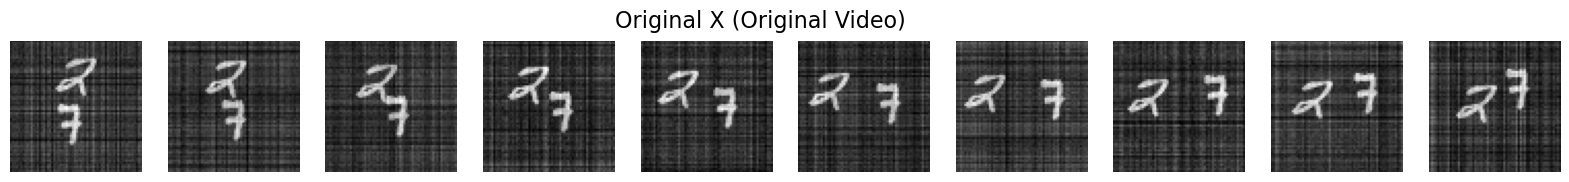

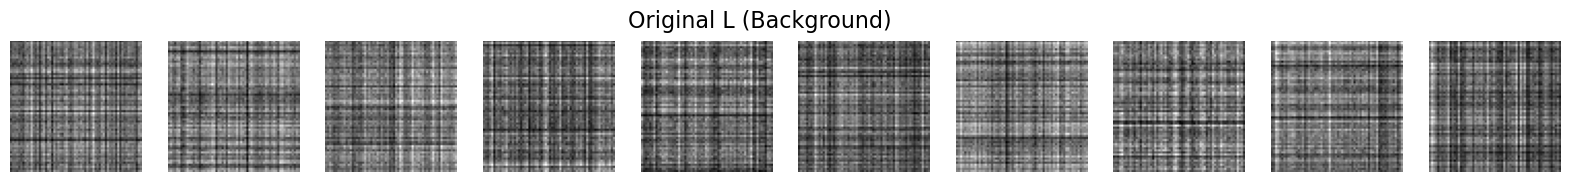

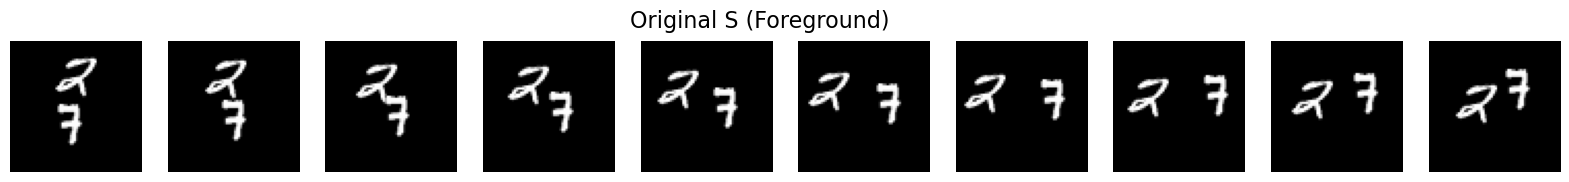



Transformed L_new shape: torch.Size([1, 4096, 10])
Transformed S_new shape: torch.Size([1, 4096, 10])
Transformed X_new shape: torch.Size([1, 4096, 10])


In [5]:
# Display the shape of original data (X)
print("Original X shape:", X.shape)
print("Original L shape:", L.shape)
print("Original S shape:", S.shape)

# Plot the first video frames of original X, L, and S
def plot_video_frames(data, title):
    video_idx = 0  # Selecting the first video (index 0)
    frames = data[:10]  # Shape: (10, 64, 64)

    # Create a figure with 10 subplots (one for each frame)
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(10):
        axs[i].imshow(frames[i], cmap='gray')
        axs[i].axis('off')

    plt.show()

# Plot original X, L, and S
print("\nPlots for Original")
plot_video_frames(X, "Original X (Original Video)")
plot_video_frames(L, "Original L (Background)")
plot_video_frames(S, "Original S (Foreground)")

# Simulating transformation via the dataset
# L_new, S_new, X_new represent transformed data after the dataloader
L_new, S_new, X_new = dataset[0]  # Dataset returns transformed tensors

# Display the shape of transformed data (L_new, S_new, X_new)
print("\n")
print("Transformed L_new shape:", L_new.shape)
print("Transformed S_new shape:", S_new.shape)
print("Transformed X_new shape:", X_new.shape)


Now design a neural network with up to 5 layers based on the intuition for low rank and sparse solutions developed above. Each layer should contain two branches for performing proximal operations for the low rank and sparse component respectively.

During training, plot the following:
1. MSE Loss as a function of the number of epochs.
2. Final values of learnt thresholding parameters for the L and S brances as a function of layer number.

For the test data, plot the following two charts by averaging over all points:
1. Low Rank:
  - 3D plot showing layer number and index of singular value on the x and y axes and the singular values themselves on the z axis.

2. Sparse:
  - 2D plot showing layer number on the x axis and number of sparse values on the y axis.

In [6]:
class ISTABlock(nn.Module):
    def __init__(self, branch, kernel_size=3):
        """Initialize the ISTA block with linear layers and a learnable threshold."""
        super(ISTABlock, self).__init__()
        self.branch = branch  # 'L' or 'S'

        # Since each frame is a vector of size 4096, we can use Linear layers
        self.linear1 = nn.Linear(4096, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 4096)

        # Initialize learnable threshold parameter
        self.threshold = nn.Parameter(torch.tensor(0.1))
    
    def _soft(self, X, thr):
        """Apply soft-thresholding to the input tensor."""
        return torch.sign(X) * torch.nn.functional.relu(torch.abs(X) - thr)
    
    def _svt(self, X, thr):
        """Apply Singular Value Thresholding (SVT) to the input tensor."""
        batch_size, time_steps, num_features = X.shape
        # Reshape X to (batch_size * time_steps, 64, 64)
        X_reshaped = X.view(-1, 64, 64)
        # Perform SVD on each frame
        U, S, Vh = torch.linalg.svd(X_reshaped)
        # Apply thresholding
        S_thresholded = torch.nn.functional.relu(S - thr)
        # Reconstruct the frames
        S_thresholded = torch.diag_embed(S_thresholded)
        X_reconstructed = torch.matmul(U, torch.matmul(S_thresholded, Vh))
        # Flatten back to original shape
        X_reconstructed = X_reconstructed.view(batch_size, time_steps, -1)
        return X_reconstructed

    def forward(self, L_k, S_k, X):
        """Perform the forward pass through the ISTA block based on the branch type."""
        if self.branch == 'L':
            out = self.linear1(L_k) + self.linear2(S_k) + self.linear3(X)
            out = self._svt(out, self.threshold)
        elif self.branch == 'S':
            out = self.linear1(L_k) + self.linear2(S_k) + self.linear3(X)
            out = self._soft(out, self.threshold)
        return out

class UnfoldedDNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with ISTA blocks for both 'S' and 'L' branches."""
        super(UnfoldedDNN, self).__init__()
        num_layers = configs["num_layers"]
        self.L_layers = nn.ModuleList()
        self.S_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.L_layers.append(ISTABlock('L'))
            self.S_layers.append(ISTABlock('S'))
    
    def get_thresholds(self):
        """Return the thresholds from both branches of the network."""
        thresholds_L = [layer.threshold.item() for layer in self.L_layers]
        thresholds_S = [layer.threshold.item() for layer in self.S_layers]
        return thresholds_L, thresholds_S
    
    def forward(self, X):
        """Perform the forward pass through the unfolded neural network and return activations."""
        activations_L = []
        activations_S = []
        batch_size, time_steps, num_features = X.shape
        L_k = torch.zeros_like(X)
        S_k = torch.zeros_like(X)
        for L_layer, S_layer in zip(self.L_layers, self.S_layers):
            L_k = L_layer(L_k, S_k, X)
            S_k = S_layer(L_k, S_k, X)
            activations_L.append(L_k)
            activations_S.append(S_k)
        return (activations_L, activations_S), (L_k, S_k)

Now Train the Model and evaluate the outputs. Complete the plotting functions and feel free to change the configurations or training settings

In [7]:
def plot_mse_loss(epoch_losses):
    """
    Plot MSE loss over epochs.
    """
    plt.figure()
    plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
    plt.title('MSE Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()


def plot_threshold_params(L_params, S_params):
    """
    Plot threshold parameters for L and S branches across layers.
    """
    # Get thresholds from the last epoch
    last_L_params = L_params[-1]
    last_S_params = S_params[-1]
    layers = range(1, len(last_L_params)+1)
    plt.figure()
    plt.plot(layers, last_L_params, label='L Branch')
    plt.plot(layers, last_S_params, label='S Branch')
    plt.title('Threshold Parameters vs Layer Number')
    plt.xlabel('Layer Number')
    plt.ylabel('Threshold Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_singular_values(L_):
    """
    Calculate singular values from the low-rank component.
    Handles input of shape [batch_size, time_steps, num_features].
    """
    batch_size, time_steps, num_features = L_.shape
    
    singular_values_list = []

    for i in range(batch_size):
        for t in range(time_steps):
            l = L_[i, t, :].cpu().numpy()
            # Reshape if needed to ensure it forms a 2D matrix for SVD
            if len(l.shape) == 1:
                l = l.reshape(-1, 1)
            
            U, S, Vh = np.linalg.svd(l, full_matrices=False)
            singular_values_list.append(S)

    # Convert the list to an array for easier manipulation
    singular_values_array = np.array(singular_values_list)
    avg_singular_values = np.mean(singular_values_array, axis=0)

    return avg_singular_values


def get_sparsity(S_, tol=1e-6):
    """
    Calculate sparsity (number of non-zero elements with tolerance 10^-6) from the sparse component.
    """
    batch_size = S_.size(0)
    total_elements = S_[0].numel()
    num_nonzero_list = []
    for i in range(batch_size):
        s = S_[i]
        num_nonzero = (torch.abs(s) > tol).sum().item()
        num_nonzero_list.append(num_nonzero)
    avg_num_nonzero = np.mean(num_nonzero_list)
    return avg_num_nonzero

def plot_singular_values_over_layers(singular_values):
    """
    Plot singular values for each layer as a 3D surface plot.
    """
    singular_values = np.array(singular_values).transpose()  # Shape: (num_layers, num_singular_values)
    num_layers, num_singular_values = singular_values.shape

    # Adjust meshgrid: X for layers, Y for singular value indices
    X, Y = np.meshgrid(range(1, num_singular_values + 1), range(1, num_layers + 1))
    Z = singular_values  # Keep it as is without transposing

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface with a colormap
    surface = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    

    # Add a color bar for better interpretation
    fig.colorbar(surface, shrink=0.5, aspect=5)

    # Set labels and title
    ax.set_xlabel('Singular Value Index')
    ax.set_ylabel('Layer Number')
    ax.set_zlabel('Singular Value')
    ax.set_title('Singular Values over Layers')

    # Adjust view angle for better visualization
    ax.view_init(30, -30)

    plt.show()


def plot_sparse_values_over_layers(sparse_values):
    """
    Plot average number of sparse values across layers.
    """
    layers = range(1, len(sparse_values)+1)
    plt.figure()
    plt.plot(layers, sparse_values, marker='o')
    plt.title('Average Number of Sparse Values over Layers')
    plt.xlabel('Layer Number')
    plt.ylabel('Average Number of Non-zero Elements')
    plt.grid(True)
    plt.show()

In [8]:
from tqdm import tqdm

def train(model, train_loader, loss_fn, optimizer, configs):
    model.train()
    epoch_losses = []
    L_params = []
    S_params = []

    for epoch in range(configs["epochs"]):
        running_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{configs['epochs']}]", unit="batch") as pbar:
            for L, S, X in pbar:
                L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
                optimizer.zero_grad()
                # Removes dimensions with size 1 along the 1st axis
                X = X.squeeze(1)
                L = L.squeeze(1)
                S = S.squeeze(1)
                # swap dimensions to [batch_size, time_steps, num_features]
                X = X.permute(0, 2, 1) 
                L = L.permute(0, 2, 1)
                S = S.permute(0, 2, 1)
                _, (L_, S_) = model(X)
                loss = loss_fn(L_, S_, L, S, X)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * L.size(0)
                pbar.set_postfix(loss=running_loss / len(train_loader.dataset))

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)

        thresholds_S, thresholds_L = model.get_thresholds()
        L_params.append(thresholds_L)
        S_params.append(thresholds_S)

        print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

    plot_mse_loss(epoch_losses)
    print("\n")
    plot_threshold_params(L_params, S_params)


def evaluate(model, test_loader, loss_fn, configs):
    model.eval()
    running_loss = 0.0
    all_sparsities = []
    all_singular_values = []

    with torch.no_grad():
        for batch_idx, (L, S, X) in enumerate(test_loader):
            # Removes dimensions with size 1 along the 1st axis
            X = X.squeeze(1)
            L = L.squeeze(1)
            S = S.squeeze(1)
            # swap dimensions to [batch_size, time_steps, num_features]
            X = X.permute(0, 2, 1) 
            L = L.permute(0, 2, 1)
            S = S.permute(0, 2, 1)
            L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
            (activations_L, activations_S), (L_ , S_)= model(X)
            loss = loss_fn(L, S, L_, S_, X)
            running_loss += loss.item() * L.size(0)

            print(f"Plot for random frame in {batch_idx}")
            plot_first_frame(L, S, X)

            batch_singular_values = []
            batch_sparsities = []
            layer_idx = 0
            for L_layer, S_layer in zip(activations_L, activations_S):
                layer_idx += 1
                singular_values = get_singular_values(L_layer)
                sparsity = get_sparsity(S_layer)
                batch_singular_values.append(singular_values[0])
                batch_sparsities.append(sparsity)
            all_singular_values.append(batch_singular_values)
            all_sparsities.append(batch_sparsities)

    avg_loss = running_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")
    print("all_singular_values:", all_singular_values)
    # avg_singular_values = np.mean(all_singular_values, axis=0)
    avg_sparsities = np.mean(all_sparsities, axis=0)
    print("all_sparsities", all_sparsities)
    print("avg_sparsities", avg_sparsities)

    plot_singular_values_over_layers(all_singular_values)
    print("\n")
    plot_sparse_values_over_layers(avg_sparsities)
    return avg_loss


def plot_first_frame(L, S, X):
    # print(L.shape)
    L_frame_flat = L[0, 0, :]  # Shape: (4096,)
    S_frame_flat = S[0, 0, :]  # Shape: (4096,)
    X_frame_flat = X[0, 0, :]  # Shape: (4096,)
    
    L_frame = L_frame_flat.view(64, 64).cpu().numpy()
    S_frame = S_frame_flat.view(64, 64).cpu().numpy()
    X_frame = X_frame_flat.view(64, 64).cpu().numpy()
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    axs[0].imshow(L_frame, cmap='gray')
    axs[0].set_title('Background (L)')
    axs[0].axis('off')
    
    axs[1].imshow(S_frame, cmap='gray')
    axs[1].set_title('Foreground (S)')
    axs[1].axis('off')
    
    axs[2].imshow(X_frame, cmap='gray')
    axs[2].set_title('Original (D)')
    axs[2].axis('off')
    
    plt.show()


def loss_fn(L_, S_, L, S, X):
    loss_L = torch.nn.functional.mse_loss(L_, L)
    loss_S = torch.nn.functional.mse_loss(S_, S)
    return loss_L + loss_S


Epoch [1/30]: 100%|██████████| 25/25 [00:52<00:00,  2.09s/batch, loss=0.0914]


Epoch: [1/30], Loss: 0.0914


Epoch [2/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.0514]


Epoch: [2/30], Loss: 0.0514


Epoch [3/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0435]


Epoch: [3/30], Loss: 0.0435


Epoch [4/30]: 100%|██████████| 25/25 [00:50<00:00,  2.02s/batch, loss=0.0379]


Epoch: [4/30], Loss: 0.0379


Epoch [5/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0333]


Epoch: [5/30], Loss: 0.0333


Epoch [6/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0307]


Epoch: [6/30], Loss: 0.0307


Epoch [7/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.0275]


Epoch: [7/30], Loss: 0.0275


Epoch [8/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.0247] 


Epoch: [8/30], Loss: 0.0247


Epoch [9/30]: 100%|██████████| 25/25 [00:50<00:00,  2.02s/batch, loss=0.0262] 


Epoch: [9/30], Loss: 0.0262


Epoch [10/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.0244]


Epoch: [10/30], Loss: 0.0244


Epoch [11/30]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/batch, loss=0.0198] 


Epoch: [11/30], Loss: 0.0198


Epoch [12/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.0171] 


Epoch: [12/30], Loss: 0.0171


Epoch [13/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.017]  


Epoch: [13/30], Loss: 0.0170


Epoch [14/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0152] 


Epoch: [14/30], Loss: 0.0152


Epoch [15/30]: 100%|██████████| 25/25 [00:51<00:00,  2.04s/batch, loss=0.0143] 


Epoch: [15/30], Loss: 0.0143


Epoch [16/30]: 100%|██████████| 25/25 [00:50<00:00,  2.02s/batch, loss=0.0136] 


Epoch: [16/30], Loss: 0.0136


Epoch [17/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.0136] 


Epoch: [17/30], Loss: 0.0136


Epoch [18/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.0123] 


Epoch: [18/30], Loss: 0.0123


Epoch [19/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0125] 


Epoch: [19/30], Loss: 0.0125


Epoch [20/30]: 100%|██████████| 25/25 [00:50<00:00,  2.02s/batch, loss=0.0113] 


Epoch: [20/30], Loss: 0.0113


Epoch [21/30]: 100%|██████████| 25/25 [00:50<00:00,  2.02s/batch, loss=0.011]  


Epoch: [21/30], Loss: 0.0110


Epoch [22/30]: 100%|██████████| 25/25 [00:50<00:00,  2.01s/batch, loss=0.0107] 


Epoch: [22/30], Loss: 0.0107


Epoch [23/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.0102] 


Epoch: [23/30], Loss: 0.0102


Epoch [24/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.011]  


Epoch: [24/30], Loss: 0.0110


Epoch [25/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.00988]


Epoch: [25/30], Loss: 0.0099


Epoch [26/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.00932]


Epoch: [26/30], Loss: 0.0093


Epoch [27/30]: 100%|██████████| 25/25 [00:51<00:00,  2.04s/batch, loss=0.00897]


Epoch: [27/30], Loss: 0.0090


Epoch [28/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.00882]


Epoch: [28/30], Loss: 0.0088


Epoch [29/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.00911]


Epoch: [29/30], Loss: 0.0091


Epoch [30/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.00863]

Epoch: [30/30], Loss: 0.0086


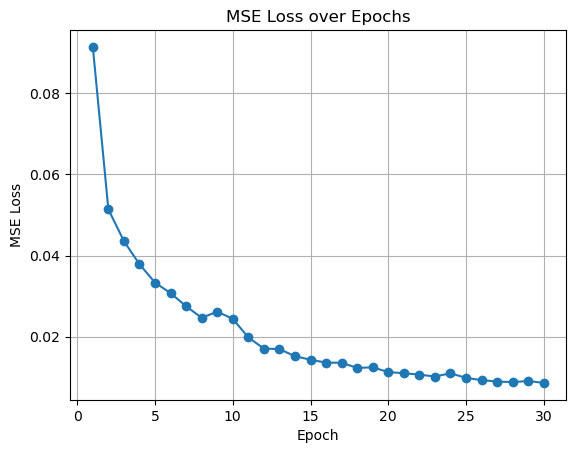

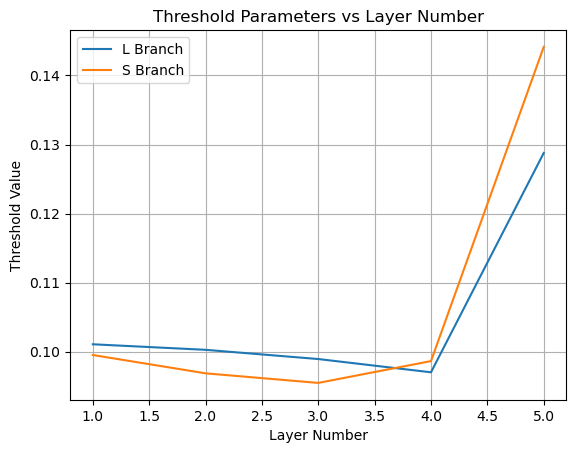

In [9]:
# Model and training configurations
configs = {
    "num_layers": 5,
    "kernel_size": 3,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize the model, optimizer, and datasets
model = UnfoldedDNN(configs).to(configs["device"])
optimizer = Adam(model.parameters(), lr=configs["lr"])

# Train the model
train(model, train_loader, loss_fn, optimizer, configs)

Plot for random frame in 0


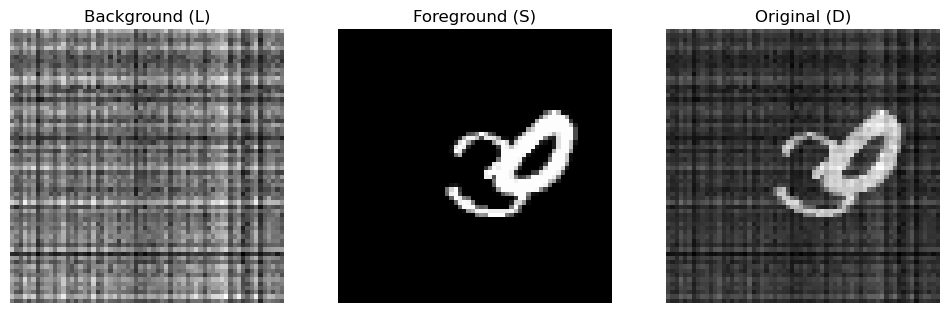

Plot for random frame in 1


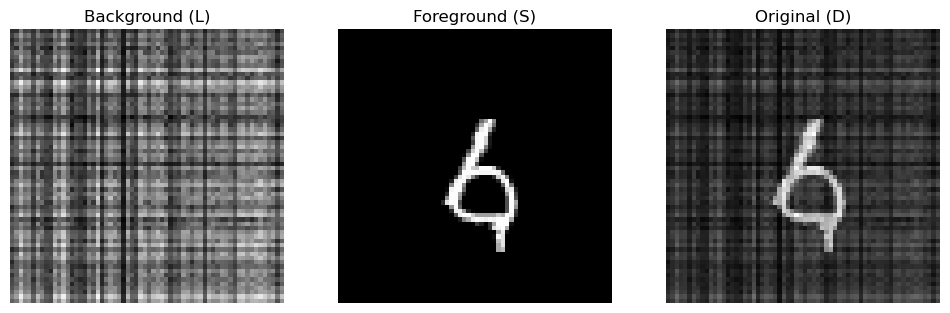

Plot for random frame in 2


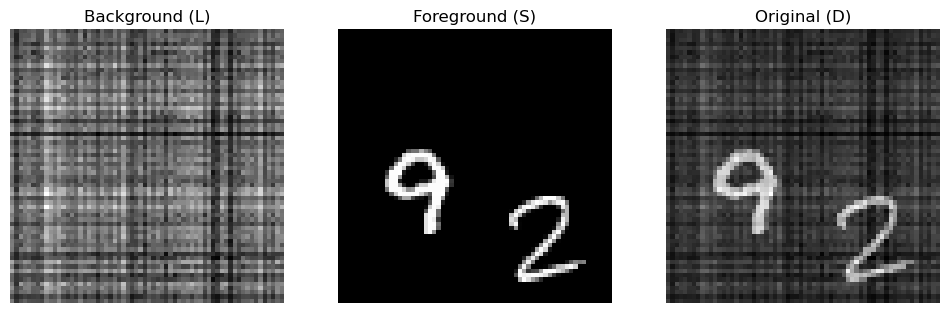

Plot for random frame in 3


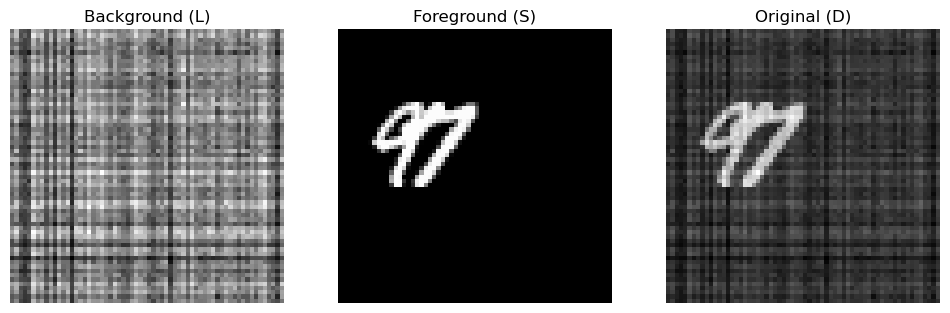

Plot for random frame in 4


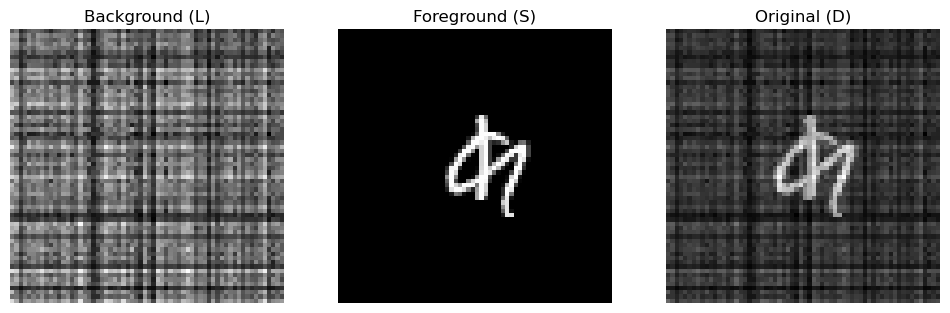

Plot for random frame in 5


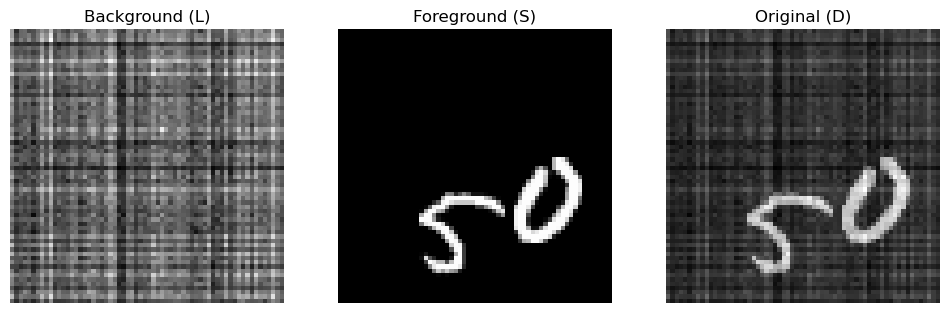

Plot for random frame in 6


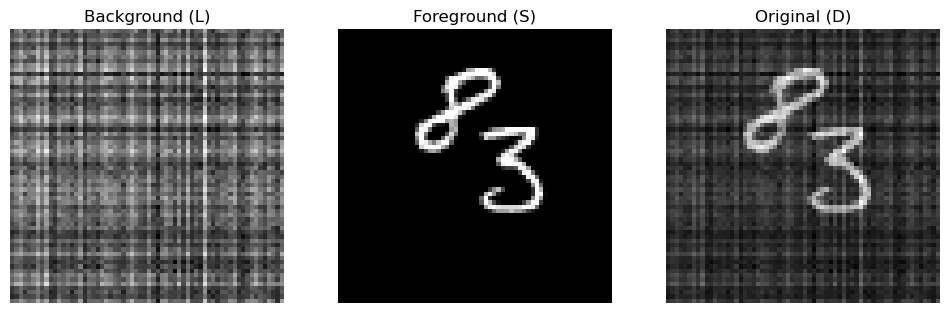

Test Loss: 0.0102
all_singular_values: [[5.8695664, 6.044584, 7.157965, 8.38072, 27.635248], [5.816428, 6.0242434, 7.138962, 8.366342, 27.278717], [5.837866, 6.016074, 7.123146, 8.354622, 27.405554], [5.8595138, 6.023295, 7.1437006, 8.363941, 27.6872], [5.859674, 6.0229554, 7.130707, 8.339528, 27.546219], [5.832196, 6.0257535, 7.1332273, 8.353791, 27.380108], [5.873128, 5.9720716, 7.0768814, 8.298312, 28.089966]]
all_sparsities [[30399.0625, 32442.5, 34859.15625, 38030.84375, 8844.4375], [30135.53125, 32304.03125, 34787.46875, 37990.53125, 8660.90625], [30258.71875, 32357.96875, 34859.8125, 38024.625, 8798.3125], [30465.8125, 32491.46875, 34931.625, 38061.40625, 8826.90625], [30342.71875, 32399.4375, 34854.53125, 38025.875, 8746.625], [30225.5625, 32305.8125, 34845.21875, 38026.5, 8768.59375], [30738.875, 32659.25, 35040.5, 38141.5, 8751.625]]
avg_sparsities [30366.61160714 32422.92410714 34882.61607143 38043.04017857
  8771.05803571]


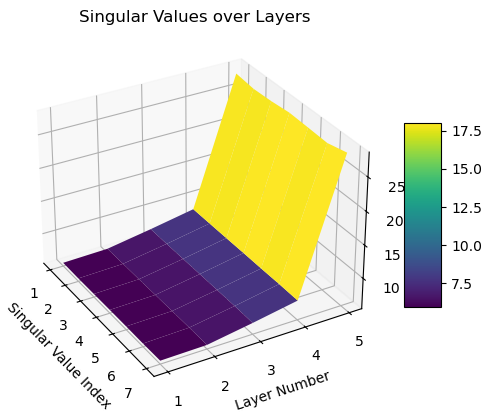

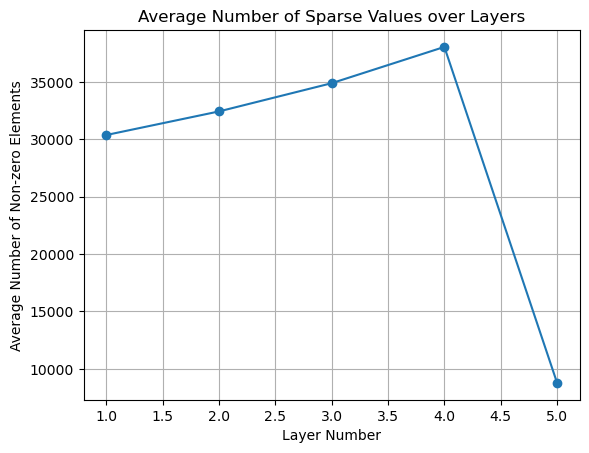

0.010191519670188427

In [57]:
# Evaluate the model
evaluate(model, test_loader, loss_fn, configs)

# Task 5: RPCA with Mixed Norms

since this is an extension of task 4, we would reuse function that are similar and update those which are changed in task 5 due to mixed norm

## Updated ISTABlock Class

- Replaced the _soft function with _prox_L12 to implement the proximal operator for the L1,2L1,2​ norm.
- Modified the forward method to call _prox_L12 instead of _soft when processing the `S` branch.

In [9]:
class ISTABlock(nn.Module):
    def __init__(self, branch, kernel_size=3):
        """Initialize the ISTA block with linear layers and a learnable threshold."""
        super(ISTABlock, self).__init__()
        self.branch = branch  # 'L' for low-rank, 'S' for sparse

        # Linear layers for affine transformations
        self.linear1 = nn.Linear(4096, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 4096)

        # Learnable threshold parameter
        self.threshold = nn.Parameter(torch.tensor(0.1))

    def _soft(self, X, thr):
        """Apply soft-thresholding to the input tensor."""
        return torch.sign(X) * torch.nn.functional.relu(torch.abs(X) - thr)

    def _svt(self, X, thr):
        """Apply Singular Value Thresholding (SVT) to the input tensor."""
        batch_size, time_steps, num_features = X.shape
        X_reshaped = X.view(-1, 64, 64)  # Reshape to perform SVD

        U, S, Vh = torch.linalg.svd(X_reshaped)
        S_thresholded = torch.nn.functional.relu(S - thr)  # Apply thresholding
        S_thresholded = torch.diag_embed(S_thresholded)

        X_reconstructed = torch.matmul(U, torch.matmul(S_thresholded, Vh))
        return X_reconstructed.view(batch_size, time_steps, -1)

    def _prox_l12(self, X, thr):
        """Apply the proximal operator for the L12-norm row-wise."""
        row_norms = torch.norm(X, p=2, dim=1, keepdim=True)
        scaling_factor = torch.nn.functional.relu(1 - thr / (row_norms + 1e-8))
        return scaling_factor * X

    def forward(self, L_k, S_k, X):
        """Perform the forward pass through the ISTA block."""
        out = self.linear1(L_k) + self.linear2(S_k) + self.linear3(X)

        if self.branch == 'L':
            out = self._svt(out, self.threshold)
        elif self.branch == 'S':
            out = self._prox_l12(out, self.threshold)  # Use L12-norm proximal
        return out

## Update Loss Function

- The new loss function ensures that the sparse component SS follows the desired structured sparsity pattern, with entire rows (or groups) being zeroed out.
- The MSE loss terms still ensure that the predicted components closely match the ground truth.
- The regularization weight λ2λ2​ allows control over the trade-off between sparsity and reconstruction accuracy.

In [10]:
def loss_fn(L_, S_, L, S, X, lambda2=0.1):
    """
    Calculate the loss for low-rank and sparse components using MSE and L12-norm.
    """
    loss_L = torch.nn.functional.mse_loss(L_, L)  # Low-rank MSE loss
    loss_S = torch.nn.functional.mse_loss(S_ + L_, X)  # Reconstruction loss

    # Compute the L12-norm for sparse component
    l12_norm = lambda2 * torch.sum(torch.norm(S_, p=2, dim=1))

    return loss_L + loss_S + l12_norm

## Updated get_sparsity Function

- Modified the function to calculate sparsity based on the number of non-zero groups (rows) instead of individual elements.
- Adjusted the computation to reflect the group sparsity promoted by the L1,2L1,2​ norm.

In [11]:
# def get_sparsity(S_, tol=1e-6, epsilon=1e-8):
#     """
#     Calculate sparsity (number of non-zero groups) from the sparse component.
#     Here, we consider each row as a group.
#     """
#     batch_size, time_steps, num_features = S_.shape
#     S_reshaped = S_.view(-1, 64, 64)  # Shape: [batch_size * time_steps, 64, 64]
#     num_nonzero_groups_list = []

#     for i in range(S_reshaped.size(0)):
#         s = S_reshaped[i]  # Shape: [64, 64]
        
#         # Compute row norms and add epsilon to avoid zero-norm issues
#         row_norms = torch.norm(s, dim=1) + epsilon  # Shape: [64]
        
#         # Count number of rows where norm > tol
#         num_nonzero_groups = (row_norms > tol).sum().item()
#         num_nonzero_groups_list.append(num_nonzero_groups)
    
#     avg_num_nonzero_groups = np.mean(num_nonzero_groups_list)
#     return avg_num_nonzero_groups

def get_singular_values(L_):
    """
    Calculate singular values from the low-rank component.
    Handles input of shape [batch_size, time_steps, num_features].
    """
    batch_size, time_steps, num_features = L_.shape
    singular_values_list = []

    for i in range(batch_size):
        for t in range(time_steps):
            l = L_[i, t, :].cpu().numpy()
            l = l.reshape(64, 64)  # Reshape to 2D matrix for SVD

            U, S, Vh = np.linalg.svd(l, full_matrices=False)
            singular_values_list.append(S)

    singular_values_array = np.array(singular_values_list)
    avg_singular_values = np.mean(singular_values_array, axis=0)

    return avg_singular_values

def get_sparsity(S_, tol=1e-6):
    """
    Calculate sparsity as the number of non-zero rows with a given tolerance.
    Row is considered non-zero if its L2-norm exceeds the tolerance.
    """
    batch_size = S_.size(0)
    num_features = S_.size(2)  # Number of columns (features)

    num_nonzero_rows_list = []

    for i in range(batch_size):
        s = S_[i]  # Shape: [time_steps, num_features]
        
        # Compute L2-norm of each row
        row_norms = torch.norm(s, p=2, dim=1)  # Shape: [time_steps]
        
        # Count rows with L2-norm > tolerance
        num_nonzero_rows = (row_norms > tol).sum().item()
        num_nonzero_rows_list.append(num_nonzero_rows)

    # Calculate the average number of non-zero rows across batches
    avg_num_nonzero_rows = np.mean(num_nonzero_rows_list)
    return avg_num_nonzero_rows


**Handling Zero Norms:** Added a small epsilon (1e-8) to row_norms to prevent division by zero during the shrinkage factor calculation.

## Retrain with Mixed Norms
We would retrain the model with the updated `ISTABlock` and `sparsity`

Epoch [1/30]: 100%|██████████| 25/25 [00:51<00:00,  2.07s/batch, loss=4.8e+3] 


Epoch: [1/30], Loss: 4799.9994


Epoch [2/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=1.64e+3]


Epoch: [2/30], Loss: 1640.7851


Epoch [3/30]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/batch, loss=1.14e+3]


Epoch: [3/30], Loss: 1135.5075


Epoch [4/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=837]


Epoch: [4/30], Loss: 836.5708


Epoch [5/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=576]


Epoch: [5/30], Loss: 576.3716


Epoch [6/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=382]


Epoch: [6/30], Loss: 382.4352


Epoch [7/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=268]


Epoch: [7/30], Loss: 267.8335


Epoch [8/30]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/batch, loss=168] 


Epoch: [8/30], Loss: 168.0525


Epoch [9/30]: 100%|██████████| 25/25 [00:51<00:00,  2.04s/batch, loss=118] 


Epoch: [9/30], Loss: 117.9302


Epoch [10/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=91.1]


Epoch: [10/30], Loss: 91.0513


Epoch [11/30]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/batch, loss=80.4]


Epoch: [11/30], Loss: 80.4175


Epoch [12/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=80.6]


Epoch: [12/30], Loss: 80.6475


Epoch [13/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=88.3]


Epoch: [13/30], Loss: 88.3376


Epoch [14/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=93.2]


Epoch: [14/30], Loss: 93.2122


Epoch [15/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=102] 


Epoch: [15/30], Loss: 102.1502


Epoch [16/30]: 100%|██████████| 25/25 [00:51<00:00,  2.04s/batch, loss=105] 


Epoch: [16/30], Loss: 105.3800


Epoch [17/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=103] 


Epoch: [17/30], Loss: 102.6378


Epoch [18/30]: 100%|██████████| 25/25 [00:51<00:00,  2.07s/batch, loss=92.4]


Epoch: [18/30], Loss: 92.3904


Epoch [19/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=90.4]


Epoch: [19/30], Loss: 90.4131


Epoch [20/30]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/batch, loss=80]  


Epoch: [20/30], Loss: 80.0364


Epoch [21/30]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/batch, loss=48.3]


Epoch: [21/30], Loss: 48.3042


Epoch [22/30]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/batch, loss=11.2]


Epoch: [22/30], Loss: 11.2135


Epoch [23/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=3.29]


Epoch: [23/30], Loss: 3.2890


Epoch [24/30]: 100%|██████████| 25/25 [00:51<00:00,  2.04s/batch, loss=1.57] 


Epoch: [24/30], Loss: 1.5659


Epoch [25/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=1.11] 


Epoch: [25/30], Loss: 1.1080


Epoch [26/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.845]


Epoch: [26/30], Loss: 0.8448


Epoch [27/30]: 100%|██████████| 25/25 [00:51<00:00,  2.07s/batch, loss=0.746]


Epoch: [27/30], Loss: 0.7465


Epoch [28/30]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/batch, loss=0.601]


Epoch: [28/30], Loss: 0.6005


Epoch [29/30]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/batch, loss=0.527]


Epoch: [29/30], Loss: 0.5274


Epoch [30/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.504]

Epoch: [30/30], Loss: 0.5036


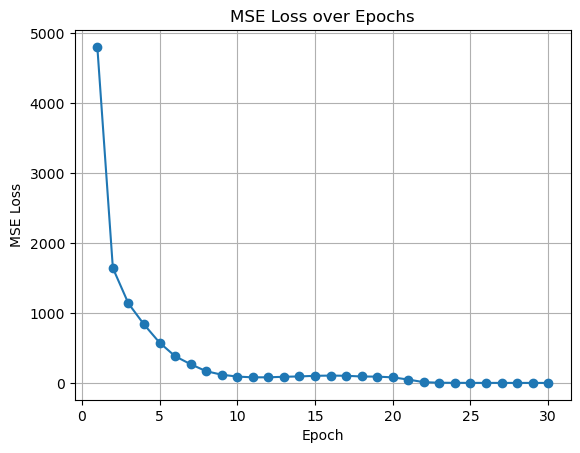

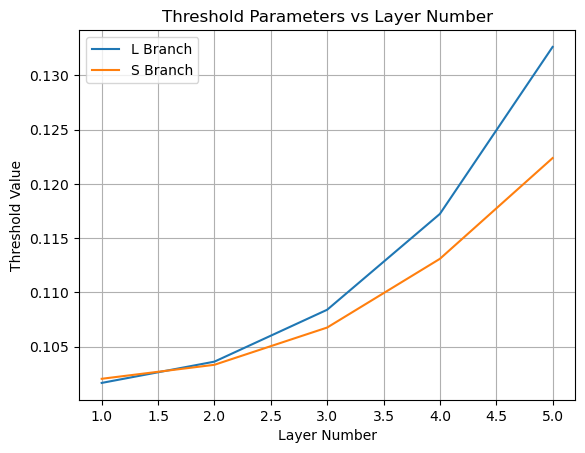

In [12]:
# Model and training configurations
configs = {
    "num_layers": 5,
    "kernel_size": 3,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize the model, optimizer, and datasets
model = UnfoldedDNN(configs).to(configs["device"])
optimizer = Adam(model.parameters(), lr=configs["lr"])

# Train the model
train(model, train_loader, loss_fn, optimizer, configs)

Plot for random frame in 0


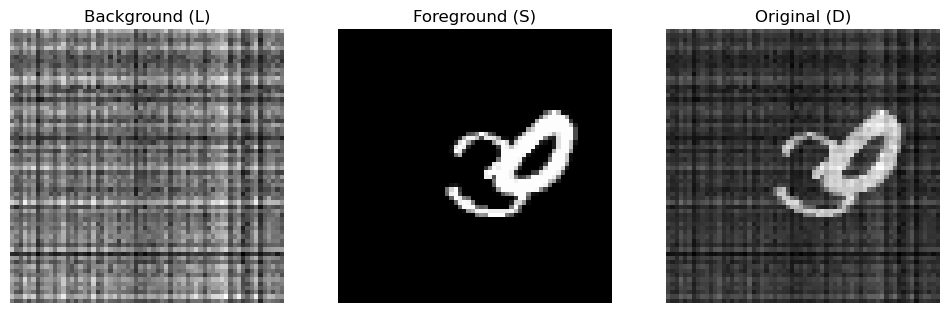

Plot for random frame in 1


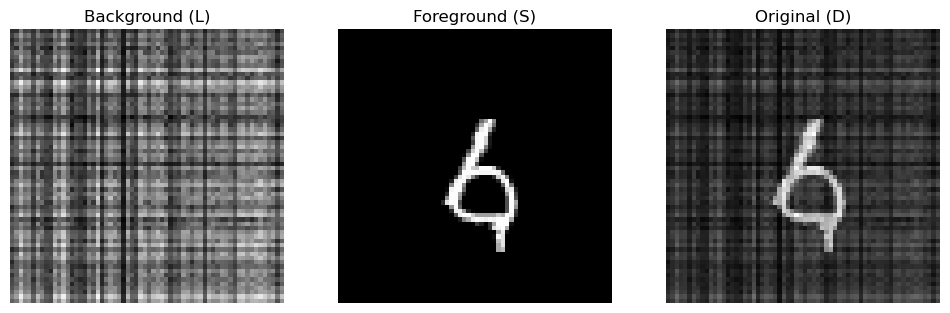

Plot for random frame in 2


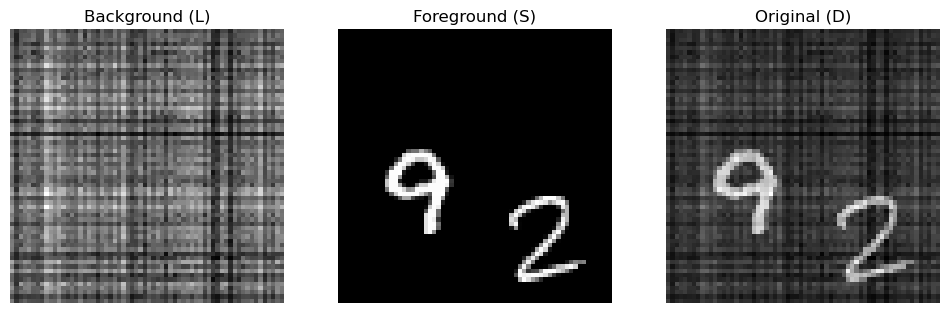

Plot for random frame in 3


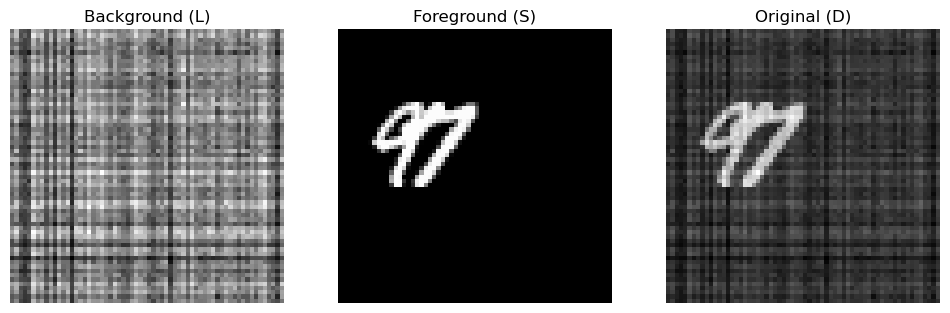

Plot for random frame in 4


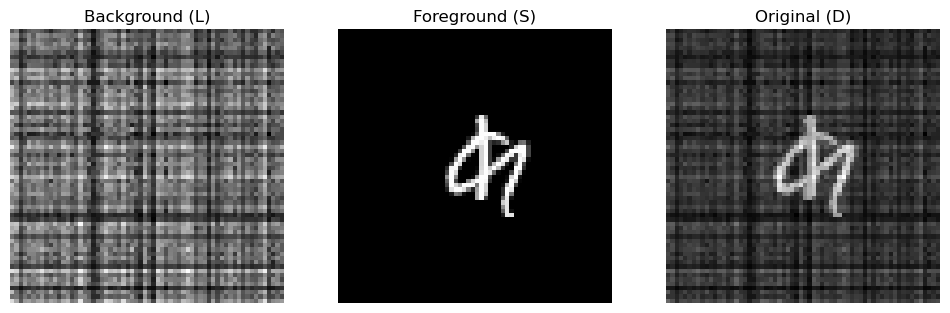

Plot for random frame in 5


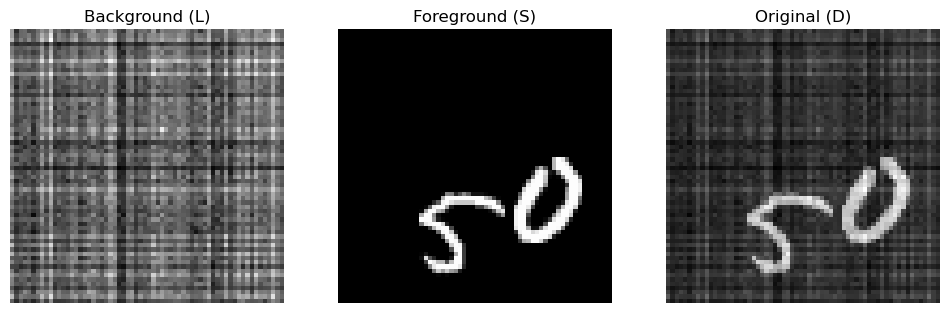

Plot for random frame in 6


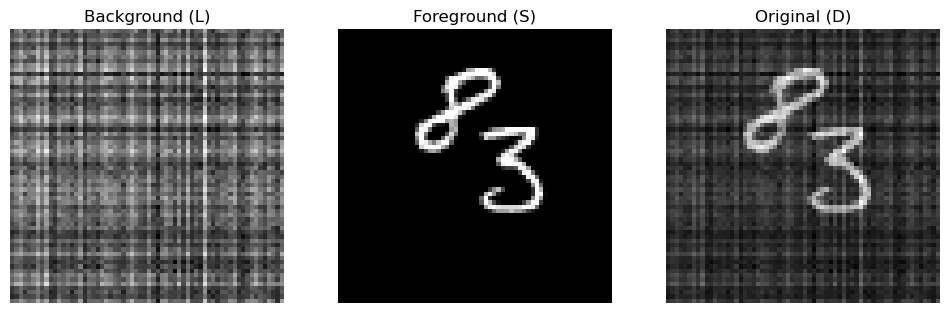

Test Loss: 4771.4806
all_singular_values: [[1.7524763, 1.3684416, 1.3018352, 1.240955, 1.1062392], [1.7317078, 1.3672664, 1.2950579, 1.2373133, 1.1014675], [1.7394041, 1.3688807, 1.2941464, 1.2309471, 1.1044354], [1.7509677, 1.3604636, 1.2923083, 1.2292703, 1.0966905], [1.7481346, 1.3670093, 1.2983339, 1.2375009, 1.1016037], [1.7403433, 1.3639109, 1.2948172, 1.2346513, 1.100405], [1.7532812, 1.3545182, 1.2854106, 1.2135355, 1.0923953]]
all_sparsities [[10.0, 10.0, 10.0, 10.0, 10.0], [10.0, 10.0, 10.0, 10.0, 10.0], [10.0, 10.0, 10.0, 10.0, 10.0], [10.0, 10.0, 10.0, 10.0, 10.0], [10.0, 10.0, 10.0, 10.0, 10.0], [10.0, 10.0, 10.0, 10.0, 10.0], [10.0, 10.0, 10.0, 10.0, 10.0]]
avg_sparsities [10. 10. 10. 10. 10.]


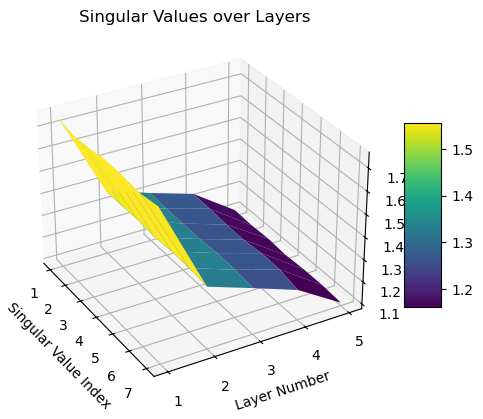

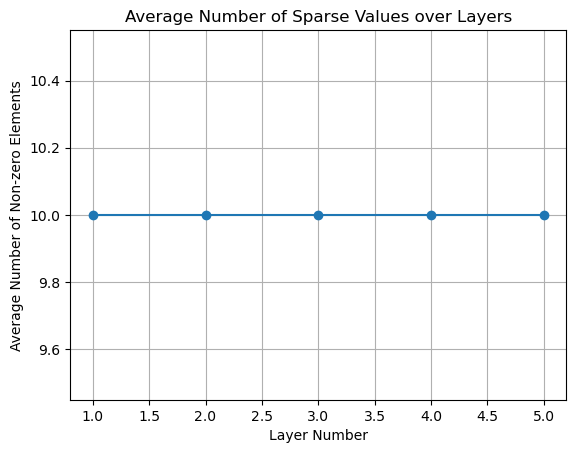

4771.480561523437

In [13]:
# Evaluate the model
evaluate(model, test_loader, loss_fn, configs)